In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
from zayd import fista
import timeit
from itertools import combinations

# 1. Preliminaries

## Load basis functions

In [3]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels. (1.6 times overcomplete?)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

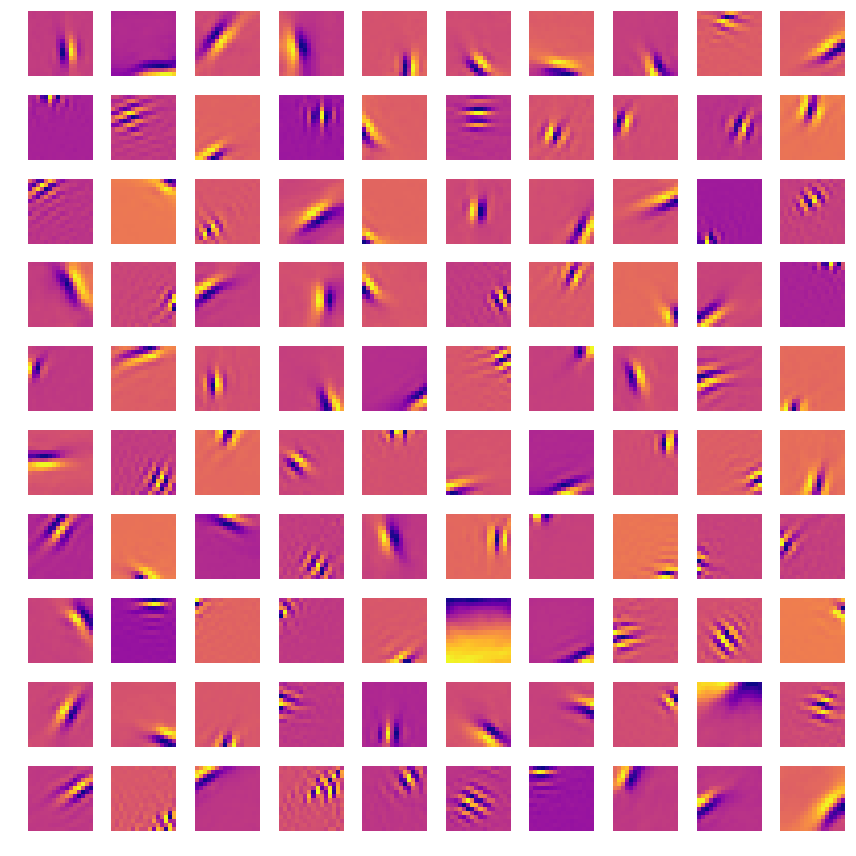

In [8]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

j = 0
for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [12]:
IMAGES = scipy.io.loadmat('./zayd/IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

512 10


In [32]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I
    

In [34]:
I = sample_images(1000, IMAGES)

In [38]:
ahat = fista.fista(I, bases, lambdav = 0.1, max_iterations=50)

range(0, 5)


In [65]:
for i,j in combinations(range(300),2):
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    if abs(corr) > 0.35 and i != j:
        print(i,j)

64 290


-0.364589709974


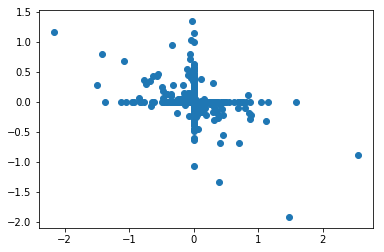

In [66]:
plt.scatter(ahat[64,:], ahat[290,:])
print(np.corrcoef(ahat[64,:], ahat[290,:])[0, 1])
plt.show()

In [67]:
def add_noise(image, sigma = 1e-2):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

In [68]:
I = sample_images(1, IMAGES)

In [ ]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [83,73]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

In [20]:

imi = np.ceil(num_images * random.uniform(0, 1))
image_numbers = []

In [319]:
imi = np.ceil(num_images * random.uniform(0, 1))
batch_size = 10000
border = 4
patch_dim = 256
sz = 16
I = np.zeros((patch_dim,batch_size))

for i in range(batch_size):
    r = border + np.ceil((imsize-sz-2*border) * random.uniform(0, 1))
    c = border + np.ceil((imsize-sz-2*border) * random.uniform(0, 1))
    image = IMAGES[int(r):int(r+sz), int(c):int(c+sz), int(imi-1)]
    #plt.imshow(image)
    #plt.show()
    I[:,i] = np.reshape(image, patch_dim) #order = 1?
    

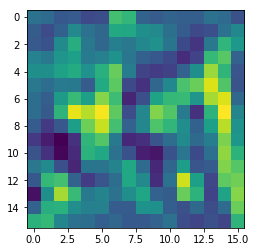

In [329]:
plt.imshow(np.reshape(I[:,6203], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

In [320]:
lambdav = 0.1

ahat = fista.fista(I, bases, lambdav, max_iterations=50)
print(ahat.shape)
print(bases.shape[1])

(300, 10000)
300


In [383]:
num_trials = 1000
responses = np.zeros((bases.shape[1], num_trials))
selected_image = np.reshape(I[:,6218], (256,1))

"""1894
2572
2615
2999
3591
6203"""

for i in range(num_trials):
    ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav, max_iterations = 50)
    responses[:, i] = ahat2[:, 0]

In [322]:
for i in range(300):
    neuron1 = responses[i,:]
    for j in range(300):
        neuron2 = responses[j,:]
        
        if abs(np.corrcoef(neuron1,neuron2)[0, 1]) > 0.7 and i !=j:
            print(i,j)
            
def plot_neurons(i,j):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()
    


C:\Users\Nick\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Nick\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


37 250
44 250
90 173
138 141
141 138
173 90
197 250
250 37
250 44
250 197


0 7
1 56
1 76
1 187
3 42
4 43
4 264
5 145
7 0
7 43
8 15
8 140
8 274
9 99
9 177
9 209
10 54
10 189
10 234
10 246
11 48
12 38
13 57
13 65
13 166
14 143
14 195
14 228
15 8
15 71
16 236
16 245
17 40
17 273
19 52
19 60
20 72
20 178
21 46
21 240
21 282
22 149
22 220
22 266
22 295
24 102
25 47
25 270
26 169
27 90
27 173
28 154
28 266
28 295
29 220
31 51
31 91
31 117
31 287
33 193
34 229
34 263
34 273
35 194
35 271
36 246
37 156
37 169
37 197
37 253
38 12
39 54
40 17
40 202
40 273
41 240
42 3
42 220
42 292
43 4
43 7
43 264
44 250
44 299
45 115
45 170
46 21
46 137
46 208
46 282
47 25
47 228
47 270
48 11
48 50
49 243
49 266
50 48
51 31
51 63
51 278
51 291
52 19
52 60
54 10
54 39
54 222
54 246
55 171
56 1
57 13
57 125
57 269
58 148
58 221
58 299
59 63
59 275
60 19
60 52
61 122
63 51
63 59
64 218
64 288
64 290
65 13
65 269
66 163
66 196
66 296
67 81
67 159
67 184
67 226
68 227
69 98
69 127
69 178
71 15
71 130
71 182
72 20
73 83
73 189
74 209
74 216
74 252
75 174
76 1
76 187
78 237
79 259
81 67
82 

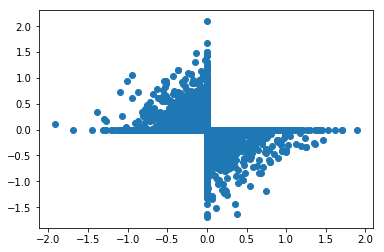

-0.15891323548


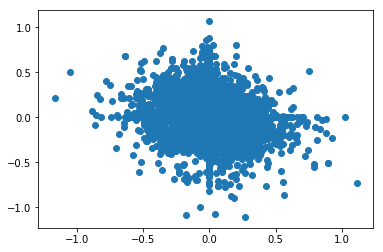

In [374]:
plt.scatter(ahat[83,:], ahat[73,:])
print(np.corrcoef(ahat[83,:], ahat[73,:])[0, 1])
plt.show()

In [382]:
for i in range(len(ahat[90,:])):
    if abs(ahat[83,:][i]) > 0.6 and abs(ahat[73,:][i]) > 0.6:
        print(i)

151
6218
7344


0.19068007272


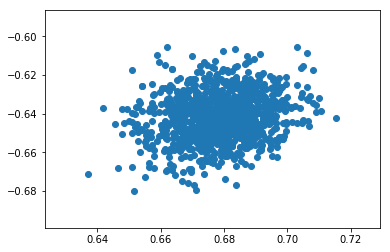

In [387]:
plot_neurons(73,83)

256


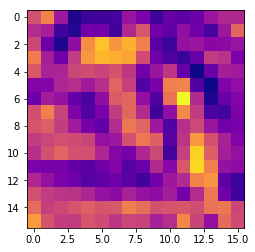

In [265]:
reco = np.dot(bases, responses[:, 27])
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
print(reco.size)
plt.show()

88
90
118
141
173
282


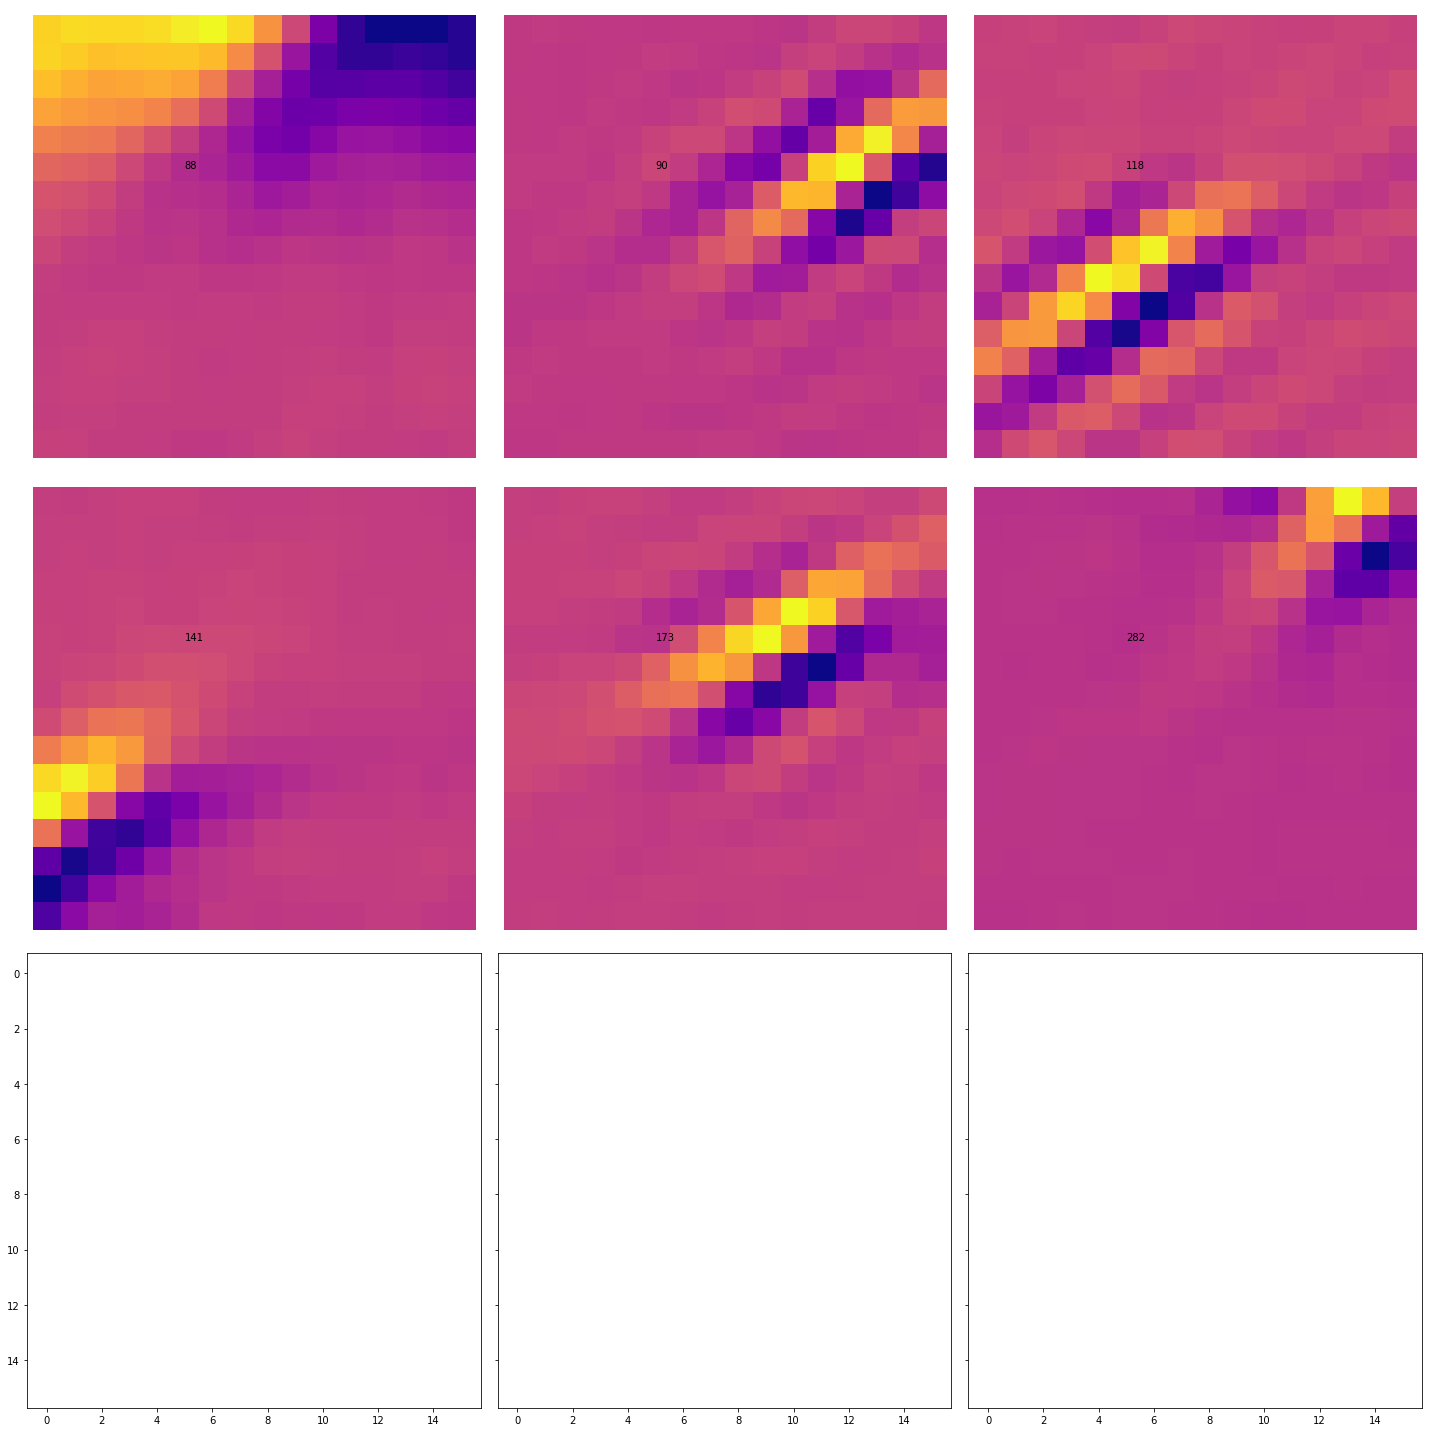

In [304]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i]) > 0.5:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

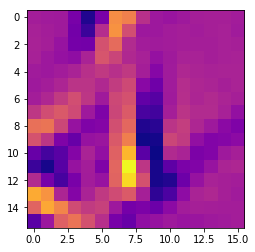

In [74]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [47]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

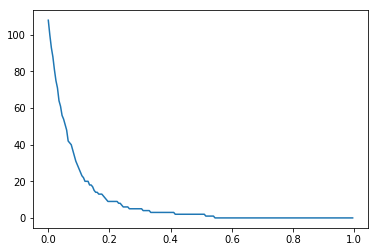

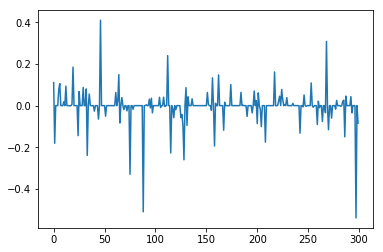

In [33]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()

In [34]:
error = I - reco

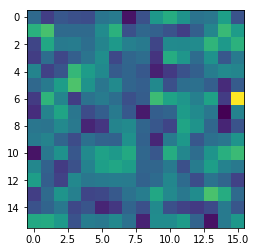

In [35]:
plt.imshow(np.reshape(error, (pixels,pixels)))
plt.show()

In [36]:
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})


In [37]:
print(I)

[[-0.036]
 [-0.039]
 [-0.073]
 [-0.061]
 [-0.067]
 [-0.012]
 [0.004]
 [-0.179]
 [-0.144]
 [0.045]
 [0.196]
 [0.213]
 [0.168]
 [0.239]
 [0.382]
 [0.317]
 [0.055]
 [0.117]
 [-0.021]
 [-0.028]
 [-0.022]
 [0.032]
 [0.088]
 [-0.047]
 [-0.088]
 [-0.079]
 [0.049]
 [0.108]
 [0.096]
 [0.244]
 [0.496]
 [0.465]
 [-0.069]
 [0.073]
 [-0.010]
 [-0.028]
 [-0.016]
 [0.043]
 [0.081]
 [0.022]
 [-0.051]
 [-0.088]
 [0.101]
 [0.162]
 [0.153]
 [0.334]
 [0.473]
 [0.400]
 [-0.106]
 [-0.020]
 [-0.045]
 [0.013]
 [0.043]
 [0.055]
 [-0.007]
 [-0.031]
 [-0.085]
 [-0.078]
 [0.187]
 [0.218]
 [0.151]
 [0.320]
 [0.406]
 [0.326]
 [-0.010]
 [-0.059]
 [-0.029]
 [0.150]
 [0.163]
 [0.099]
 [-0.012]
 [-0.056]
 [-0.099]
 [-0.128]
 [-0.003]
 [0.040]
 [-0.021]
 [0.001]
 [0.010]
 [-0.008]
 [0.006]
 [0.039]
 [0.089]
 [0.147]
 [0.125]
 [0.097]
 [0.009]
 [-0.099]
 [-0.064]
 [0.007]
 [-0.018]
 [0.000]
 [-0.003]
 [-0.100]
 [-0.232]
 [-0.058]
 [-0.048]
 [0.112]
 [0.130]
 [0.017]
 [-0.001]
 [0.054]
 [0.025]
 [-0.095]
 [-0.065]
 [0.127

In [168]:
print(reco)

[[-0.407]
 [-0.511]
 [-0.694]
 [-0.603]
 [-0.302]
 [-0.060]
 [0.051]
 [-0.092]
 [-0.257]
 [-0.248]
 [-0.223]
 [-0.202]
 [-0.206]
 [-0.358]
 [-0.554]
 [-0.313]
 [-0.294]
 [-0.441]
 [-0.566]
 [-0.497]
 [-0.427]
 [-0.043]
 [0.422]
 [0.184]
 [-0.324]
 [-0.341]
 [-0.297]
 [-0.314]
 [-0.125]
 [-0.079]
 [-0.380]
 [-0.423]
 [-0.182]
 [-0.458]
 [-0.492]
 [-0.371]
 [-0.544]
 [-0.382]
 [0.017]
 [-0.067]
 [-0.382]
 [-0.324]
 [-0.326]
 [-0.489]
 [-0.356]
 [-0.115]
 [-0.172]
 [-0.358]
 [0.029]
 [-0.447]
 [-0.634]
 [-0.545]
 [-0.720]
 [-0.727]
 [-0.476]
 [-0.245]
 [-0.185]
 [-0.134]
 [-0.235]
 [-0.505]
 [-0.618]
 [-0.456]
 [-0.222]
 [-0.193]
 [0.191]
 [-0.275]
 [-0.678]
 [-0.742]
 [-0.699]
 [-0.459]
 [-0.035]
 [0.254]
 [0.187]
 [0.118]
 [0.085]
 [-0.092]
 [-0.352]
 [-0.495]
 [-0.426]
 [-0.249]
 [0.035]
 [-0.258]
 [-0.618]
 [-0.545]
 [-0.071]
 [0.330]
 [0.657]
 [0.689]
 [0.260]
 [-0.017]
 [0.073]
 [0.208]
 [0.161]
 [-0.014]
 [-0.326]
 [-0.468]
 [-0.224]
 [-0.397]
 [-0.406]
 [0.067]
 [0.717]
 [0.741]
 

In [169]:
print(error)

[[-0.002]
 [-0.021]
 [-0.075]
 [-0.052]
 [0.001]
 [0.013]
 [-0.013]
 [0.011]
 [-0.011]
 [0.005]
 [-0.004]
 [0.013]
 [0.017]
 [-0.028]
 [-0.108]
 [0.061]
 [-0.013]
 [-0.049]
 [-0.008]
 [0.030]
 [0.002]
 [0.056]
 [0.115]
 [0.035]
 [-0.035]
 [-0.016]
 [0.018]
 [0.029]
 [0.007]
 [0.031]
 [0.010]
 [-0.082]
 [0.034]
 [-0.039]
 [-0.016]
 [-0.030]
 [-0.031]
 [-0.032]
 [-0.030]
 [-0.019]
 [0.001]
 [0.008]
 [0.008]
 [-0.015]
 [-0.018]
 [-0.001]
 [0.014]
 [-0.071]
 [0.039]
 [-0.010]
 [0.017]
 [-0.015]
 [-0.019]
 [0.006]
 [0.031]
 [0.002]
 [-0.004]
 [0.010]
 [-0.002]
 [-0.030]
 [-0.060]
 [-0.047]
 [-0.013]
 [0.017]
 [0.081]
 [-0.011]
 [-0.037]
 [-0.045]
 [-0.046]
 [-0.080]
 [-0.027]
 [0.032]
 [-0.008]
 [-0.013]
 [-0.006]
 [-0.016]
 [-0.060]
 [-0.025]
 [-0.021]
 [-0.015]
 [-0.008]
 [0.017]
 [-0.018]
 [-0.045]
 [0.042]
 [0.021]
 [0.005]
 [0.067]
 [-0.036]
 [-0.043]
 [0.015]
 [0.022]
 [0.028]
 [0.039]
 [0.021]
 [-0.035]
 [-0.007]
 [0.039]
 [-0.011]
 [0.032]
 [0.064]
 [0.035]
 [-0.013]
 [0.013]
 [-0.0

In [172]:
print("%.3f" % np.average(abs(error)))

0.028
